In [1]:
# Analisi

In [3]:
%pip install networkx matplotlib pandas python-louvain

Note: you may need to restart the kernel to use updated packages.


In [ ]:
## 1. Setup

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import pandas as pd
from collections import defaultdict
import matplotlib.cm as cm

file_name = 'dataset/Hi-tech.paj'

try:
    # 1. Carica il MultiDiGraph
    G_multi = nx.read_pajek(file_name)
    
    # 2. Converte in DiGraph, mantenendo solo un arco per coppia (se presente)
    G = nx.DiGraph(G_multi).copy()

    # Vengono considerati nodi: Partition, Hi-tech_union.clu, Vertices
    trash = [node for node, data in G.nodes(data=True) if data == {}]
    G.remove_nodes_from(trash)
    
    # Pulizia e Ridenominazione dei Nodi (robustezza)
    mapping = {node: int(node) for node in G.nodes() if str(node).isdigit()}
         
    G = nx.relabel_nodes(G, mapping, copy=False)

    print(f"Grafo caricato con successo: {G.number_of_nodes()} nodi e {G.number_of_edges()} archi.")

except FileNotFoundError:
    print(f"ERRORE: Il file '{file_name}' non è stato trovato.")
    print("Assicurati di aver scaricato il file e posizionato nella stessa cartella del notebook.")
except Exception as e:
    print(f"Si è verificato un errore durante il caricamento del file: {e}")

Grafo caricato con successo: 36 nodi e 147 archi.


## 2. Analisi Esplorativa

In [49]:
# Verifica delle proprietà del grafo
is_direct_result = G.is_directed()  
print("Il grafo è diretto (amicizia non reciproca):", is_direct_result) 
is_bipartite_result = nx.is_bipartite(G)
print("Il grafo è bipartito:", is_bipartite_result)
is_unweighted_result = all('weight' not in data for u, v, data in G.edges(data=True))
print("Il grafo è non ponderato:", is_unweighted_result)

print("\n--- Statistiche Base ---")
print("Numero di nodi (Impiegati): ", G.number_of_nodes())
print("Numero di archi (Amicizie): ", G.number_of_edges())

# Componenti
# Per grafi diretti si usano le componenti fortemente connesse (Strongly Connected Components - SCC)
scc = list(nx.strongly_connected_components(G))
print(f'Numero di componenti fortemente connesse (SCC): {len(scc)}')
print(f'Dimensione della SCC più grande: {len(max(scc, key=len))}')

# Densità
density = nx.density(G)
print(f'Densità della rete: {density:.4f}')

Il grafo è diretto (amicizia non reciproca): True
Il grafo è bipartito: False
Il grafo è non ponderato: False

--- Statistiche Base ---
Numero di nodi (Impiegati):  36
Numero di archi (Amicizie):  147
Numero di componenti fortemente connesse (SCC): 7
Dimensione della SCC più grande: 30
Densità della rete: 0.1167


## 3. Analisi della connettività e centralità

### 3.1 Connettività (Degree)

Nodi ordinati per Indegree (popolarità, dal più alto al più basso):
Nodo: Chris, Indegree: 12
Nodo: Rick, Indegree: 11
Nodo: Tom, Indegree: 10
Nodo: Ken, Indegree: 9
Nodo: Dale, Indegree: 8


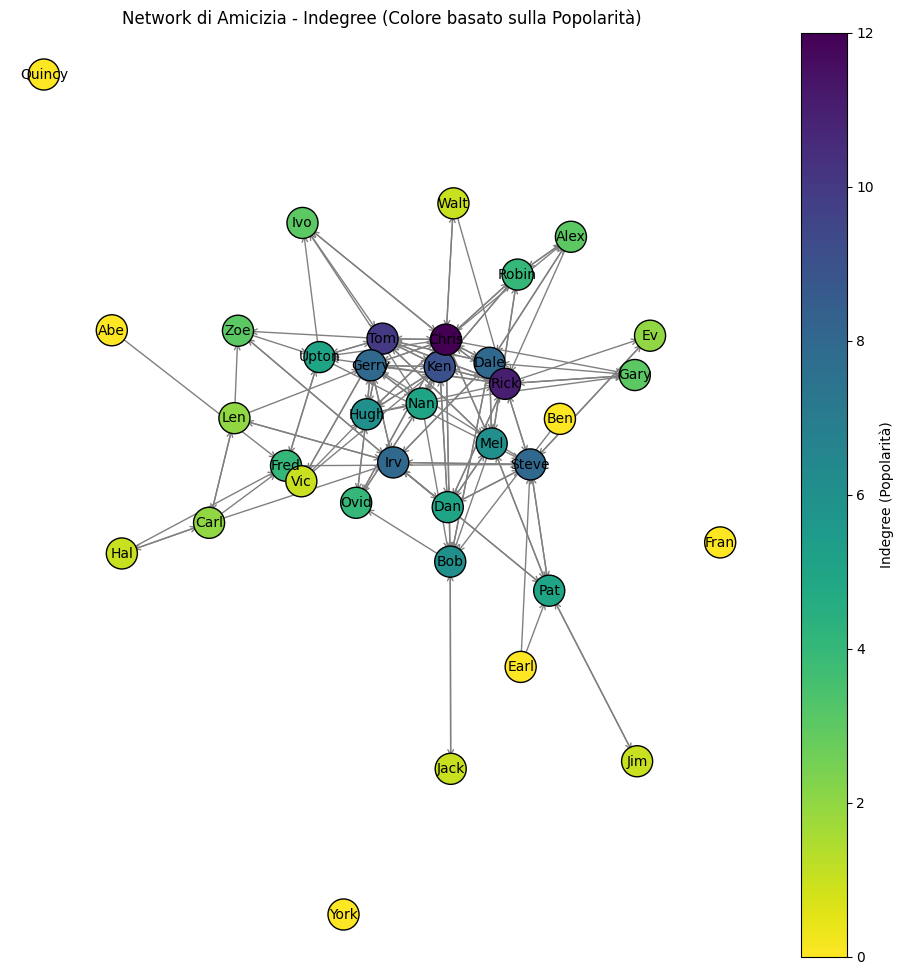

In [58]:
# Calcola il grado in ingresso (popolarità) e in uscita (socievolezza)
indegree_dict = dict(G.in_degree())
outdegree_dict = dict(G.out_degree())

# Ordina in base all'Indegree (più popolari)
sorted_indegrees = sorted(indegree_dict.items(), key=lambda x: x[1], reverse=True)
print("Nodi ordinati per Indegree (popolarità, dal più alto al più basso):")
for node, degree in sorted_indegrees[:5]:
    print(f"Nodo: {node}, Indegree: {degree}")

# Visualizzazione del Grado (Indegree)
colors = [indegree_dict[node] for node in G.nodes()]
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Colormaps: 'viridis' o 'plasma'
cmap_name = 'viridis_r' 
base_cmap = plt.colormaps.get_cmap(cmap_name) 

nodes = nx.draw_networkx_nodes(G, pos, node_size=500, node_color=colors, cmap=base_cmap, edgecolors="black")
edges = nx.draw_networkx_edges(G, pos, edge_color="gray", arrowstyle='->', arrowsize=10)
labels = nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Barra colori (Nota: networkx disegna su plt.gca(), quindi la colorbar funziona)
plt.colorbar(nodes, label='Indegree (Popolarità)')
plt.title(f"Network di Amicizia - Indegree (Colore basato sulla Popolarità)")
plt.axis('off')
plt.show()

### 3.2 Centralità

In [60]:
G_undirected = G.to_undirected()

# 1. Degree Centrality (popolarità/socievolezza relativa)
# Si usa la In-Degree per l'importanza di ricevere legami
degree_centrality = nx.in_degree_centrality(G) 
sorted_degree_centrality = {k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)}
print("Degree Centrality (Indegree, dalla più grande alla più piccola):")
for node, centrality in list(sorted_degree_centrality.items())[:5]:
    print(f"Nodo {node}: {centrality:.4f}")

print("\n----------------------------------")

# 2. Betweenness Centrality (broker: si usa G_undirected per percorsi brevi)
betweenness_centrality = nx.betweenness_centrality(G_undirected)
sorted_betweenness_centrality = {k: v for k, v in sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)}
print("Betweenness Centrality (dalla più grande alla più piccola):")
for node, centrality in list(sorted_betweenness_centrality.items())[:5]:
    print(f"Nodo {node}: {centrality:.4f}")

print("\n----------------------------------")

# 3. Closeness Centrality (efficienza: si usa G_undirected per percorsi brevi)
closeness_centrality = nx.closeness_centrality(G_undirected)
sorted_closeness = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)
print("Closeness Centrality (dalla più grande alla più piccola):")
for node, closeness in sorted_closeness[:5]:
    print(f"{node}: {closeness:.4f}")

print("\n----------------------------------")

# 4. Eigenvector Centrality (importanza: connessioni a nodi importanti)
eigenvector_centrality = nx.eigenvector_centrality(G_undirected, max_iter=1000)
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
print("Eigenvector Centrality (dalla più grande alla più piccola):")
for node, eigenvector in sorted_eigenvector[:5]:
    print(f"{node}: {eigenvector:.4f}")

Degree Centrality (Indegree, dalla più grande alla più piccola):
Nodo Chris: 0.3429
Nodo Rick: 0.3143
Nodo Tom: 0.2857
Nodo Ken: 0.2571
Nodo Dale: 0.2286

----------------------------------
Betweenness Centrality (dalla più grande alla più piccola):
Nodo Chris: 0.1627
Nodo Bob: 0.1091
Nodo Steve: 0.1089
Nodo Rick: 0.1050
Nodo Upton: 0.0937

----------------------------------
Closeness Centrality (dalla più grande alla più piccola):
Chris: 0.5520
Rick: 0.5133
Tom: 0.4876
Upton: 0.4876
Gerry: 0.4876

----------------------------------
Eigenvector Centrality (dalla più grande alla più piccola):
Chris: 0.4067
Rick: 0.3397
Tom: 0.3144
Ken: 0.2764
Gerry: 0.2753


## 4. Community detection e Clique

### 4.1 community detection

Coefficiente di clustering medio (G non diretto): 0.4155

--- Comunità ---
Numero di comunità trovate: 7
Modularità della rete: 0.2948


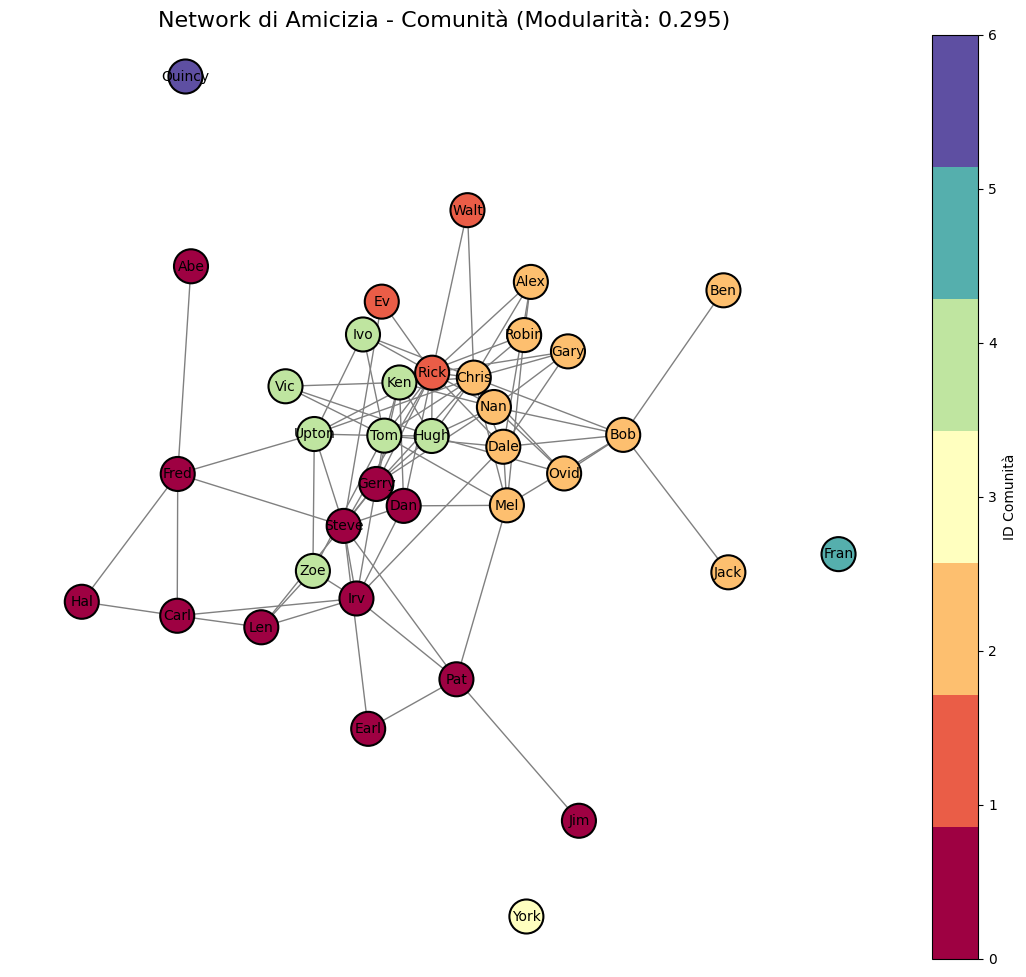

In [63]:
# In[5]:
# Calcola il coefficiente di clustering medio (quanto i vicini sono collegati tra loro)
clustering_coefficient = nx.average_clustering(G_undirected)
print(f"Coefficiente di clustering medio (G non diretto): {clustering_coefficient:.4f}")

# Trova le comunità usando l'algoritmo Louvain (su grafo non diretto)
partition = community_louvain.best_partition(G_undirected)
modularity = community_louvain.modularity(partition, G_undirected)
num_communities = len(set(partition.values()))

print("\n--- Comunità ---")
print("Numero di comunità trovate:", num_communities)
print(f"Modularità della rete: {modularity:.4f}")
# print("Valori delle partizioni (Comunità ID per Nodo):")
# print(partition)

# Aggiunge l'informazione delle comunità ai nodi
nx.set_node_attributes(G_undirected, partition, 'community')

# Visualizzazione delle Comunità (Con le correzioni per la Colorbar e la Colormap)
fig, ax = plt.subplots(figsize=(14, 12)) 
pos = nx.spring_layout(G_undirected, seed=42, k=0.5)

# Correzione del cmap e type error
base_cmap = plt.colormaps.get_cmap('Spectral') 
cmap = base_cmap.resampled(num_communities)

node_colors = [partition[node] for node in G_undirected.nodes()]

nodes = nx.draw_networkx_nodes(
    G_undirected, pos, node_color=node_colors, node_size=600, 
    cmap=cmap, edgecolors='black', linewidths=1.5, ax=ax
)

nx.draw_networkx_edges(G_undirected, pos, edge_color='gray', ax=ax)
nx.draw_networkx_labels(G_undirected, pos, font_size=10, font_color="black", ax=ax)

ax.set_title(f"Network di Amicizia - Comunità (Modularità: {modularity:.3f})", fontsize=16)
ax.axis('off')

# Colorbar: passa sm, ticks e ax
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_communities - 1))
sm.set_array([]) # Necessario per alcune versioni di Matplotlib
cbar = fig.colorbar(sm, ticks=range(num_communities), ax=ax)
cbar.set_label('ID Comunità')

plt.show()

### 4.2 Clique e K-core Analysis

Top 5 clique massimali per dimensione:
Clique 1 (Dimensione 6): ['Chris', 'Rick', 'Tom', 'Gerry', 'Ken', 'Hugh']
Clique 2 (Dimensione 5): ['Chris', 'Nan', 'Hugh', 'Ken', 'Gerry']
Clique 3 (Dimensione 4): ['Chris', 'Mel', 'Dale', 'Bob']
Clique 4 (Dimensione 4): ['Chris', 'Mel', 'Dale', 'Tom']
Clique 5 (Dimensione 4): ['Chris', 'Ivo', 'Tom', 'Upton']

--- K-Core Analysis ---
Core numbers (massima coesione di appartenenza):
Nodo Ken: core number 5
Nodo Tom: core number 5
Nodo Rick: core number 5
Nodo Chris: core number 5
Nodo Gerry: core number 5

Nodi nel K-core (K=5): ['Hugh', 'Gerry', 'Rick', 'Tom', 'Ken', 'Chris']


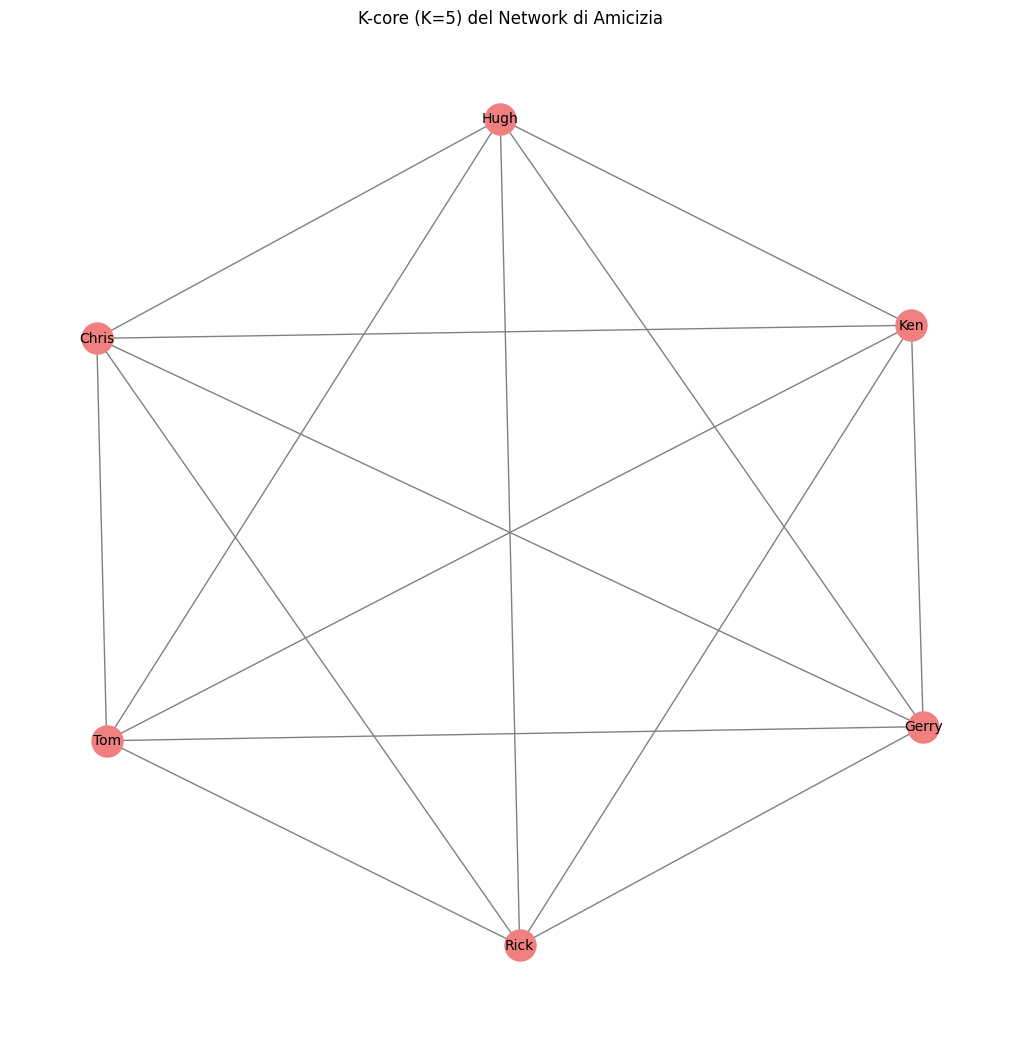

In [64]:
# Trova tutte le clique massimali nella rete (su grafo non diretto)
cliques = list(nx.find_cliques(G_undirected)) 
sorted_cliques = sorted(cliques, key=len, reverse=True)

print("Top 5 clique massimali per dimensione:")
for i, clique in enumerate(sorted_cliques[:5]):
    print(f"Clique {i+1} (Dimensione {len(clique)}): {clique}")

print("\n--- K-Core Analysis ---")

# Core Numbers
core_numbers = nx.core_number(G_undirected)
sorted_cores = sorted(core_numbers.items(), key=lambda item: item[1], reverse=True)
print("Core numbers (massima coesione di appartenenza):")
for node, core_number in sorted_cores[:5]:
    print(f"Nodo {node}: core number {core_number}")

# Visualizzazione del K-core (usiamo il k-core massimo trovato - il primo in lista)
max_k = sorted_cores[0][1] if sorted_cores else 0
if max_k > 0:
    k_core = nx.k_core(G_undirected, k=max_k)
    core_nodes = k_core.nodes()
    
    print(f"\nNodi nel K-core (K={max_k}):", list(core_nodes))
    
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(k_core, seed=42)
    nx.draw(k_core, pos, with_labels=True, node_size=500, node_color="lightcoral", edge_color="gray", font_size=10, font_color="black")
    plt.title(f"K-core (K={max_k}) del Network di Amicizia")
    plt.axis('off')
    plt.show()
else:
     print("Non è stato trovato un K-core significativo (K > 0).")

# 5. Assortività

In [65]:
# Assortatività (tendenza dei nodi con alto grado a connettersi con altri nodi con alto grado)
degree_assortativity = nx.degree_assortativity_coefficient(G_undirected)
print(f"Coefficiente di assortatività per grado (G non diretto): {degree_assortativity:.4f}")

if degree_assortativity > 0:
    print("La rete è assortativa: gli impiegati popolari tendono ad essere amici di altri impiegati popolari.")
elif degree_assortativity < 0:
    print("La rete è disassortativa: gli impiegati popolari tendono ad essere amici di impiegati con poche connessioni.")
else:
    print("La rete è neutra in termini di assortatività per grado.")

Coefficiente di assortatività per grado (G non diretto): -0.0874
La rete è disassortativa: gli impiegati popolari tendono ad essere amici di impiegati con poche connessioni.
